# Interface the Image Container object with Tensorflow models

In this tutorial, we show how you can use the Image Container object to train a **Resnet** model to predict cluster labels of spots.
This is a general approach that can be easily extended to a variety of supervised, self-supervised or unsupervised tasks. We aim to highlight how the flexibility provided by the image container, and it's seamles integration with **AnnData**, makes it easy to interface your data with modern deep learning frameworks such as **Tensorflow**.

Furthermore, we show how you can leverage such resent model to generate a new set of feature that can provided useful insights on spots similarity based on image morphology. 

First, we'll load some libraries. Note that `tensorflow` it's not a dependency of `squidpy` and you'd therefore have to install it separately in your conda environemnt. Have a look at [here](https://www.tensorflow.org/install). This of course apply to any deep learning framework of choice.

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import seaborn as sns
from anndata import AnnData
from sklearn.model_selection import (
    train_test_split,
)  # we'll use this function to split our dataset in train and test set
import tensorflow as tf
from tensorflow.keras.layers.experimental import (
    preprocessing,
)  # let's use the new pre-processing layers for reisizing and data augmentation tasks

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
print(f"tensorflow=={tf.__version__}")

%load_ext autoreload
%autoreload 2
%load_ext lab_black

scanpy==1.7.0rc2.dev1+g2a123065 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.2 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.2
squidpy==0.0.0
tensorflow==2.3.0-dev20200610


We will load the public data availbale in squidpy.

In [2]:
adata = sq.datasets.visium_hne_adata()
img = sq.datasets.visium_hne_image()

We can now create a generate that will load *on the fly* the image crops corresponding to the tissue present under the spots. 
In just one line of code you can cereate this generator, specifying the size of the crops as well. You might want to increase the size to include some neighborhood morphology information. 

In [3]:
spots = img.generate_spot_crops(adata, size=1.5)
spot_list = [s[0].data.to_array().values.squeeze(axis=0) for s in spots]

We then need to create a vector of our labels with which to train the classifier. In this case, we will train a classifier to predict cluster labels of Visium spot. Furthermore, we'll split the vecotr indices to get a train and test set. Note that we specify the cluster labels as `stratify` argument, to make sure that the cluster labels are balanced in each split. Finally, we'll create a one hot encoder array with the convenient function `tf.one_hot`.

In [4]:
cluster_labels = adata.obs["cluster"]
classes = cluster_labels.unique().shape[0]
cluster_map = {v: i for i, v in enumerate(cluster_labels.cat.categories.values)}
labels = np.array([cluster_map[c] for c in cluster_labels], dtype=np.uint8)
labels_ohe = tf.one_hot(labels, depth=classes, dtype=tf.float32).numpy()

In [5]:
# get train,test split stratified by cluster labels
train_idx, test_idx = train_test_split(
    np.arange(cluster_labels.shape[0]),
    test_size=0.2,
    stratify=cluster_labels,
    shuffle=True,
    random_state=42,
)

In [7]:
print(
    f"Train set : \n {adata[train_idx, :].obs.cluster.value_counts().to_markdown()} \n \n Test set: \n {adata[test_idx, :].obs.cluster.value_counts().to_markdown()}"
)

Train set : 
 |                               |   cluster |
|:------------------------------|----------:|
| Cortex_1                      |       227 |
| Thalamus_1                    |       209 |
| Cortex_2                      |       206 |
| Cortex_3                      |       195 |
| Fiber_tract                   |       181 |
| Hippocampus                   |       178 |
| Hypothalamus_1                |       166 |
| Thalamus_2                    |       154 |
| Cortex_4                      |       131 |
| Striatum                      |       122 |
| Hypothalamus_2                |       106 |
| Cortex_5                      |       103 |
| Lateral_ventricle             |        84 |
| Pyramidal_layer_dentate_gyrus |        54 |
| Pyramidal_layer               |        34 | 
 
 Test set: 
 |                               |   cluster |
|:------------------------------|----------:|
| Cortex_1                      |        57 |
| Thalamus_1                    |        52 |
| Co

Next, we'll create a tensorflow dataset which will be used as data loader for model training. We won't get too much in details of the different arguments and steps, you can familiarize youreself with tensorflow datasets [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [8]:
def create_dataset(x: list, y: np.ndarray, idx: list, augment: bool, shuffle: bool):
    ds = tf.data.Dataset.from_tensor_slices(
        ([x[i] for i in idx], y[idx, :])
    )  # create dataset from lists (x: images, y: labels)
    if shuffle:  # if you want to shuffle the dataset during training
        ds = ds.shuffle(1000, reshuffle_each_iteration=True)
    ds = ds.batch(64)  # batch
    processing_layers = [
        preprocessing.Resizing(128, 128),
        preprocessing.Rescaling(1.0 / 255),
    ]
    augment_layers = [
        preprocessing.RandomFlip(),
        preprocessing.RandomRotation(0.5),
        preprocessing.RandomContrast(0.8),
    ]
    if augment:  # if you want to augment the image crops during training
        processing_layers.extend(augment_layers)

    data_processing = tf.keras.Sequential(processing_layers)

    ds = ds.map(lambda x, y: (data_processing(x), y))  # add processing to dataset

    return ds

In [9]:
train_ds = create_dataset(spot_list, labels_ohe, train_idx, augment=True, shuffle=True)
test_ds = create_dataset(spot_list, labels_ohe, test_idx, augment=True, shuffle=True)

Here, we are actually instantiating the model. We'll use a pre-trained resnet on imagenet, and a Dense layer for output. 

In [10]:
input_shape = (128, 128, 3)  # input shape
inputs = tf.keras.layers.Input(shape=input_shape)

# load Resnet with pre-trained imagenet weights
x = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
    classes=classes,
    pooling="avg",
)(inputs)
outputs = tf.keras.layers.Dense(
    units=classes,  # add output layer
)(x)
model = tf.keras.Model(inputs, outputs)  # create model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # add optimizer
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),  # add loss
)

94773248/94765736 [==============================] - 58s 1us/step


In [11]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 15)                30735     
Total params: 23,618,447
Trainable params: 23,565,327
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
history = model.fit(train_ds, validation_data=test_ds, epochs=50, verbose=2)

Epoch 1/50
34/34 - 6s - loss: 2.0789 - val_loss: 4.2149
Epoch 2/50
34/34 - 5s - loss: 1.1989 - val_loss: 4.0142
Epoch 3/50
34/34 - 5s - loss: 0.9783 - val_loss: 7.3486
Epoch 4/50
34/34 - 5s - loss: 0.8531 - val_loss: 10.9831
Epoch 5/50
34/34 - 5s - loss: 0.7420 - val_loss: 16.2768
Epoch 6/50
34/34 - 5s - loss: 0.7070 - val_loss: 19.8687
Epoch 7/50
34/34 - 5s - loss: 0.6347 - val_loss: 13.4447
Epoch 8/50
34/34 - 5s - loss: 0.5778 - val_loss: 28.2567
Epoch 9/50
34/34 - 5s - loss: 0.5390 - val_loss: 25.1223
Epoch 10/50
34/34 - 5s - loss: 0.5298 - val_loss: 47.0279
Epoch 11/50
34/34 - 5s - loss: 0.4856 - val_loss: 27.3699
Epoch 12/50
34/34 - 5s - loss: 0.4273 - val_loss: 23.8131
Epoch 13/50
34/34 - 5s - loss: 0.4027 - val_loss: 26.2057
Epoch 14/50
34/34 - 5s - loss: 0.3476 - val_loss: 21.8520
Epoch 15/50
34/34 - 5s - loss: 0.3438 - val_loss: 14.0873
Epoch 16/50
34/34 - 5s - loss: 0.3240 - val_loss: 12.8256
Epoch 17/50
34/34 - 5s - loss: 0.3086 - val_loss: 20.7136
Epoch 18/50
34/34 - 5s - l

We can plot training and test loss during training. Clearly it would require some fine-tuning :)

<AxesSubplot:ylabel='loss'>

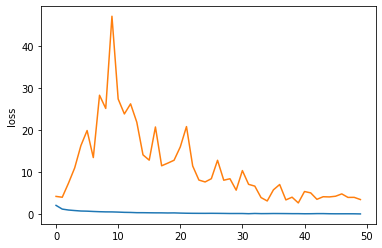

In [12]:
sns.lineplot(x=np.arange(50), y="loss", data=history.history)
sns.lineplot(x=np.arange(50), y="val_loss", data=history.history)

What we are actually interesting is the the resnet embedding values of the dataset after training. We expect that such embedding have learnt relevant features for the image that can be used for downstream analysis such as clustering or integration with gene expression.

For generating this embedding, we first create a new dataset, that contains the full list of spots, in the correct order and without augmentation.

In [13]:
full_ds = create_dataset(
    spot_list, labels_ohe, np.arange(len(spot_list)), augment=False, shuffle=False
)

Then, we instantiate another model without the output layer, in order to get the final embedding layer.

In [14]:
model_embed = tf.keras.Model(inputs, x)
embedding = model_embed.predict(full_ds)

We can then save such embedding in a new AnnData, and copy over all the relevant metadata from the AnnData with gene expression counts...

In [15]:
adata_resnet = AnnData(embedding, obs=adata.obs.copy())
adata_resnet.obsm["spatial"] = adata.obsm["spatial"].copy()
adata_resnet.uns = adata.uns.copy()

... perform the standard clustering analysis.

In [16]:
sc.pp.pca(adata_resnet)
sc.pp.neighbors(adata_resnet)
sc.tl.leiden(adata_resnet, key_added="resnet_embedding_cluster")
sc.tl.umap(adata_resnet)

Interestingly, it seems that despite the poor performance on the test set, the model has encoded some information relevant to separate spots from each other. Such clustering annotation also resembled the original annotation based on gene expression similarity.

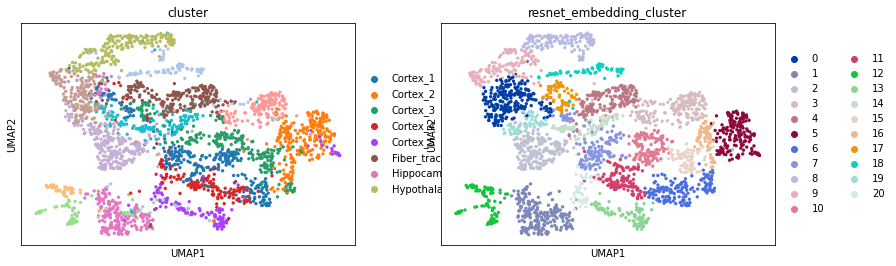

In [17]:
sc.pl.umap(adata_resnet, color=["cluster", "resnet_embedding_cluster"])

We can visualize the same information in spatial coordiantes. Again some clusters such as 12, 13 and 14 seems to closely recapitulate the Hippocampus and Pyramidal layers clusters. For the cortex instead, a lot of clusters splits the original cortical layer annotation.

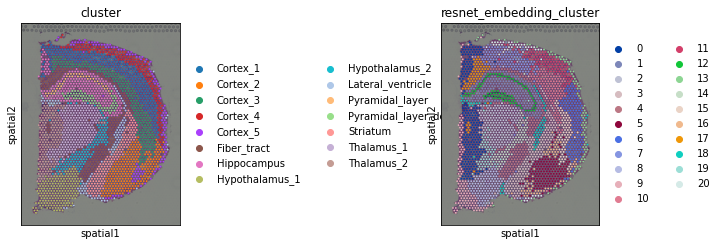

In [18]:
sc.pl.spatial(adata_resnet, color=["cluster", "resnet_embedding_cluster"])

An additional analysis could be to integrate information of both gene expression and the features learnt by the resnet classifier, in order to get a joint representation of both gene expression and image information. Such integration could be done for instance by concatenating the resulting PCA from the gene expression `adata` and the resnet embedding `adata_resnet`. After concatenating the principal components, you could follow the usual steps of building a knn graph and clusteing with the leiden algorithm. 

Wit this tutorial we have shown how to interface the squidpy workflow with modern deep learning framework, and have inspired you with additional analysis that leverage several data modalitied and powerful DL-based representations.